## STEP 1: Object detection

In [31]:
from ultralytics import YOLO
from transformers import AutoModelForCausalLM, AutoTokenizer, TextStreamer
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
import random
from PIL import Image
import sys
from sentence_transformers import SentenceTransformer, util
from transformers import set_seed

sys.path.append('..')
from llm.prompts_generator import load_model
from llava_captioning.llava_descriptor import extract_images_from_grid
from sr_mechanism.sentence_evaluator import *

../generative_images/45_dog.png


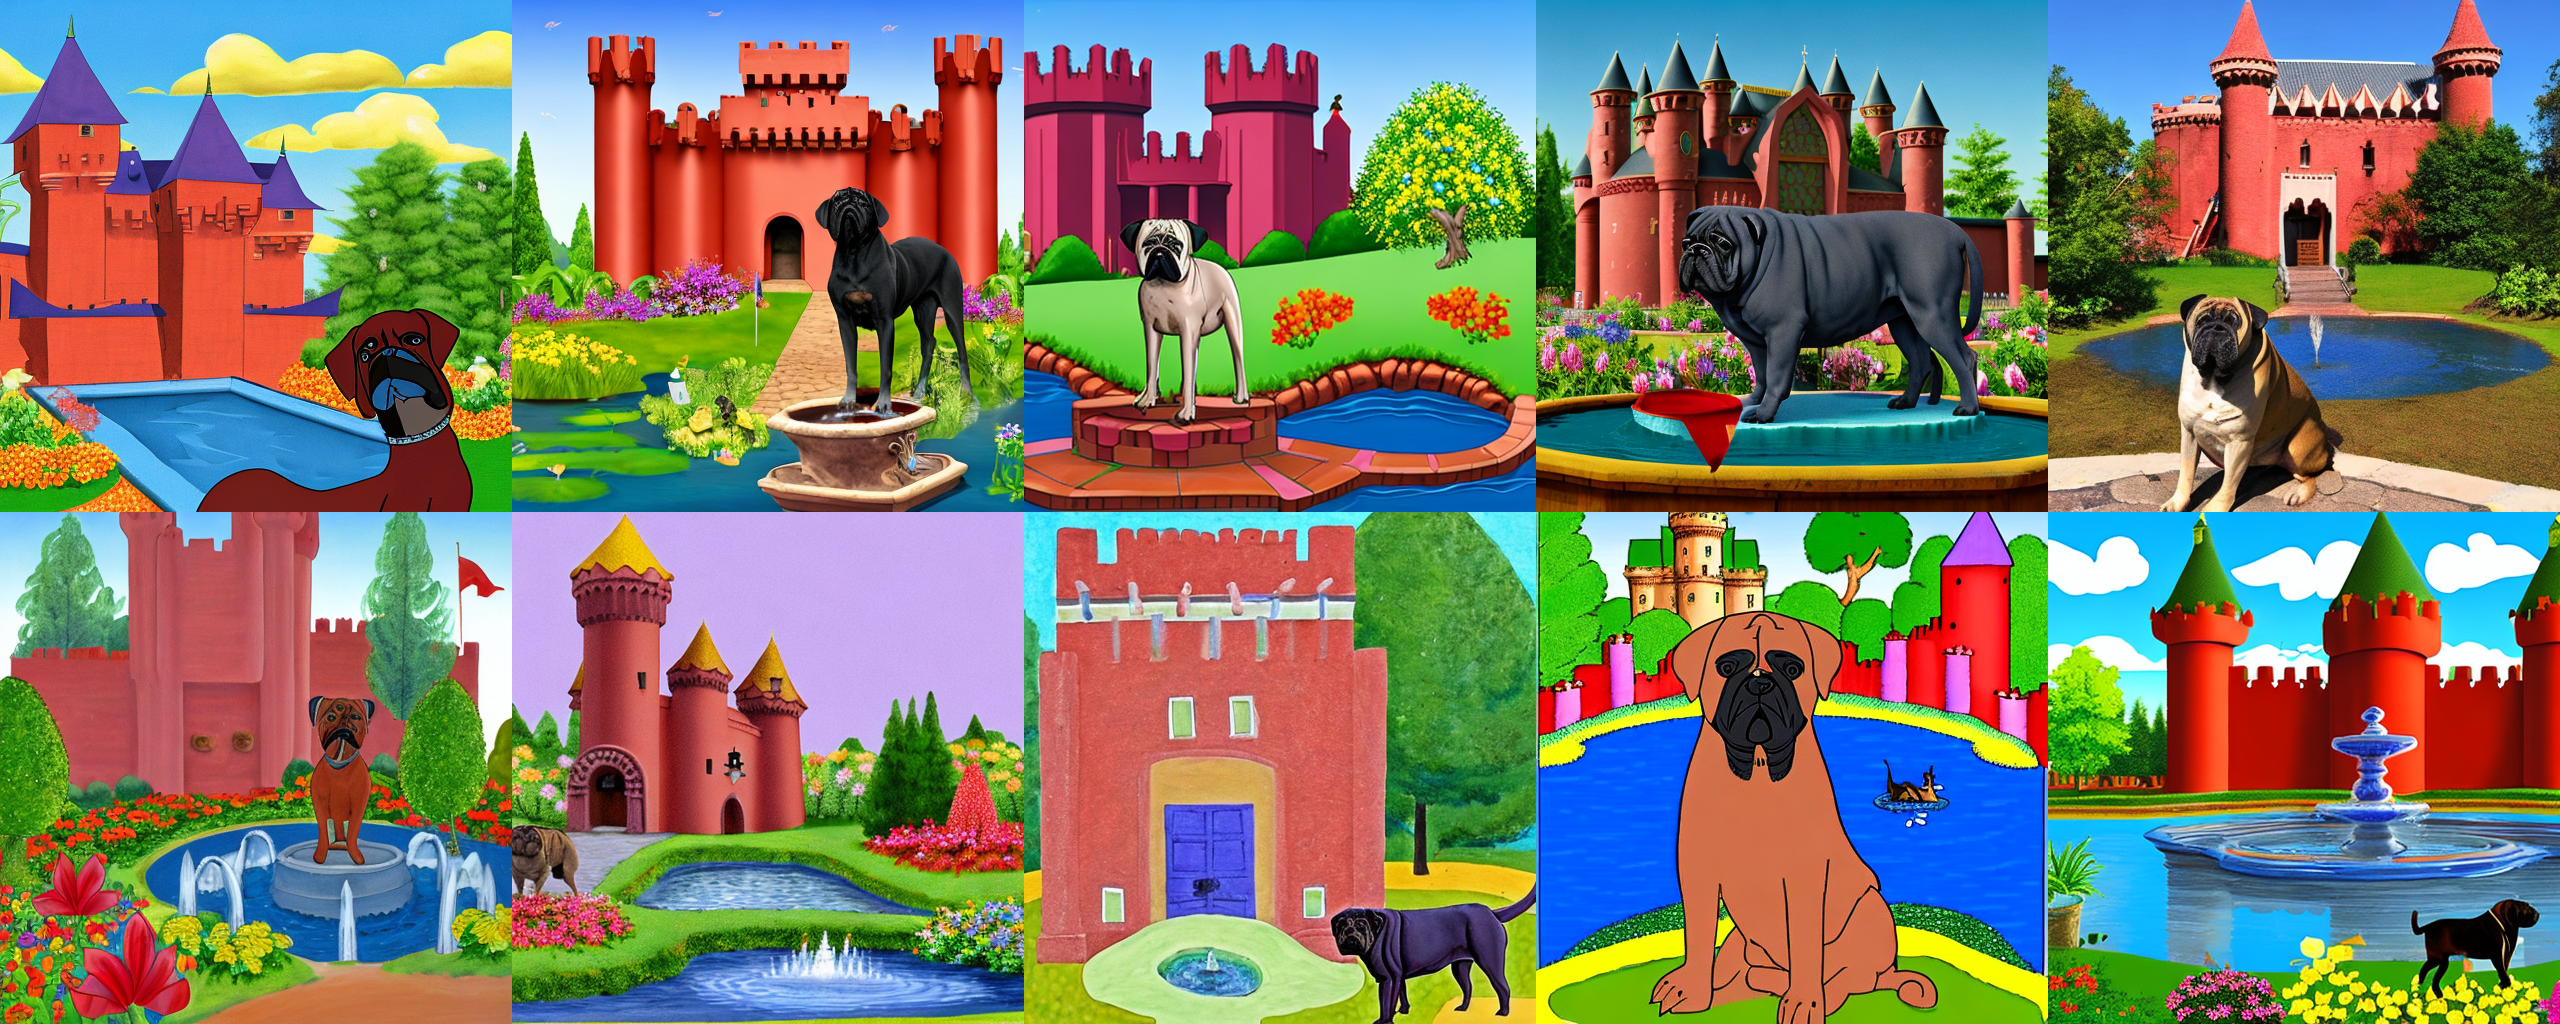

In [2]:
image_files = [f for f in os.listdir('../generative_images/') if f.endswith(('.png', '.jpg', '.jpeg'))]

img_file = os.path.join('../generative_images/', random.choice(image_files))
print(img_file)
image = Image.open(img_file)
image

## STEP 2: LLM self-judging

### let's prepare the data

In [3]:
def get_index_from_filename(filename):
    return int(filename.split('_')[0])

# Get the index from the chosen image file
indice = get_index_from_filename(os.path.basename(img_file))-1

# Rest of your code
prompt_list = []

with open('../generated_prompts.txt', 'r') as file:
    for line in file:
        class_, prompt = map(str.strip, line.split(';', 1))
        
        # Append [CLASS] and [PROMPT] to the 2D list
        prompt_list.append([class_, prompt])

if 0 <= indice < len(prompt_list):
    file_name = f"{indice + 1}_{prompt_list[indice][0]}.txt"
    
    # Read the content of the specified file
    with open(f'../generative_images_descriptions/{file_name}', 'r') as image_file:
        images_content = image_file.read()
        
    print(f'Class: {prompt_list[indice][0]}\n')
    print(f'Prompt: {prompt_list[indice][1]}\n')
    print(f'Image Content: \n{images_content}')
else:
    print(f"Index {indice} is out of range.")
    

Class: dog

Prompt: A blue bullmastiff, standing guard in front of a red castle, a yellow garden, a green fountain, a red flag, a blue pond, a purple lily.

Image Content: 
image 1: This image is most likely a drawing or art. A large red dog is standing in front of a purple castle, looking off into the distance. The dog appears to be wearing a chain around its neck. The castle is surrounded by a moat filled with water, and there are several potted plants scattered throughout the scene. In the background, there are two birds flying in the sky, adding to the overall whimsical atmosphere of the image.
image 2: This image is most likely a drawing or art. A black dog is standing in front of a large, red castle with a moat. The dog appears to be guarding the entrance to the castle. The background features a garden with a pond, where a frog can be seen sitting on a lily pad. There are also several birds scattered throughout the scene, adding to the lush and vibrant atmosphere. The abnormality

## YOLO-world to detect the class

In [5]:
sys.path.append('..')
from sr_mechanism.yolo_filter import yolo_filtering

In [15]:
class_name = [prompt_list[indice][0]]
model = YOLO('yolov8l-world.pt') 
model.set_classes(class_name)
class_name

['dog']

In [16]:
result = yolo_filtering(image, class_name)

result


0: 640x640 (no detections), 11.2ms
Speed: 4.4ms preprocess, 11.2ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 dog, 10.5ms
Speed: 1.7ms preprocess, 10.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 dog, 21.8ms
Speed: 4.3ms preprocess, 21.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 dog, 23.5ms
Speed: 4.3ms preprocess, 23.5ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 dog, 12.8ms
Speed: 2.1ms preprocess, 12.8ms inference, 0.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 dog, 10.3ms
Speed: 1.7ms preprocess, 10.3ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 dog, 22.0ms
Speed: 4.3ms preprocess, 22.0ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 dog, 11.2ms
Speed: 1.9ms preprocess, 11.2ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 64

[1, 9]


0: 640x640 (no detections), 10.2ms
Speed: 1.8ms preprocess, 10.2ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 dog, 10.5ms
Speed: 1.8ms preprocess, 10.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 dog, 10.6ms
Speed: 1.7ms preprocess, 10.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 dog, 10.5ms
Speed: 1.7ms preprocess, 10.5ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 dog, 10.6ms
Speed: 1.7ms preprocess, 10.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 dog, 10.7ms
Speed: 1.7ms preprocess, 10.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 dog, 10.6ms
Speed: 1.8ms preprocess, 10.6ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 dog, 10.9ms
Speed: 1.7ms preprocess, 10.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 64

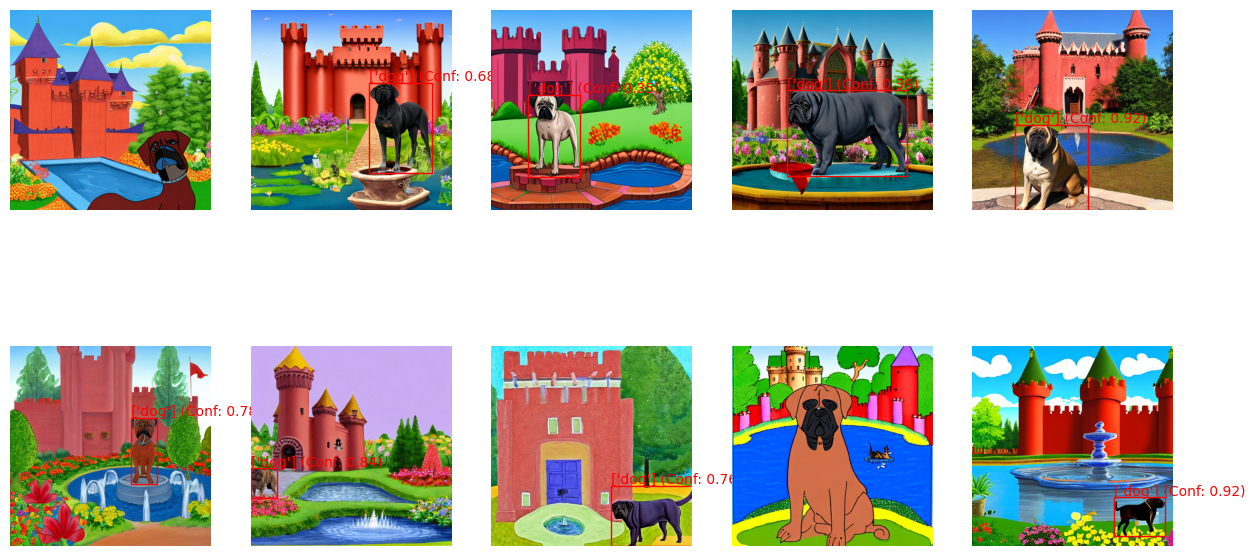

In [17]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

extracted_imgs = extract_images_from_grid(image, 2, 5)

fig, axs = plt.subplots(2, 5, figsize=(15, 8))
axs = axs.ravel()

no_detection = []

for i in range(10):
    res = model.predict(extracted_imgs[i], conf=0.1)
    
    if res[0].boxes.xyxy.cpu().numpy().any():
        for j, prediction in enumerate(res):
            boxes = prediction.boxes.xyxy.cpu().numpy()
            confidences = prediction.boxes.conf.cpu().numpy()

            for box, confidence in zip(boxes, confidences):
                x, y, w, h = box[:4]

                rect = patches.Rectangle((x, y), w - x, h - y, linewidth=1, edgecolor='r', facecolor='none')
                axs[i].add_patch(rect)

                # Display the class label and confidence value
                axs[i].text(x, y - 5, f"{class_name} (Conf: {confidence:.2f})", color='r')

        # Display the image without axes
        axs[i].imshow(extracted_imgs[i])
        axs[i].axis('off')
    else:
        no_detection.append(i+1)
        # Display the image without axes
        axs[i].imshow(extracted_imgs[i])
        axs[i].axis('off')

plt.show()


## Now LLM self-judging

In [11]:
#example of extracted lines and prompt
lines = images_content.split("\n")

let's remove the indices of images where no dog has been detected

In [24]:
lines_filtered = [line for i, line in enumerate(lines, start=1) if i not in result]
lines_filtered

["image 2: This image is most likely a drawing or art. A black dog is standing in front of a large, red castle with a moat. The dog appears to be guarding the entrance to the castle. The background features a garden with a pond, where a frog can be seen sitting on a lily pad. There are also several birds scattered throughout the scene, adding to the lush and vibrant atmosphere. The abnormality in this image is that the dog's eyes are positioned incorrectly, giving it a peculiar appearance.",
 "image 3: This image is most likely a drawing or art. A pug dog is sitting on a brick pedestal in front of a pink castle. The dog appears to be looking at the castle, which is surrounded by a moat. In the background, there is a tree with yellow flowers. The abnormality is that the dog's eyes are not aligned properly. The colors in the image are predominantly pink and yellow, with the dog being black and white.",
 'image 4: This image is most likely a drawing or art. A large black dog is standing o

In [26]:
scores_list = calculate_cosine_similarity_scores(prompt_list[indice][1], lines_filtered)

# Extract image numbers from lines_filtered
image_numbers = [int(line.split(":")[0].split()[-1]) for line in lines_filtered]

# Print image numbers and scores
for image_number, score in zip(image_numbers, scores_list):
    print(f"Image {image_number} - Score: {score}")


Image 2 - Score: 0.5160080790519714
Image 3 - Score: 0.4603022038936615
Image 4 - Score: 0.4540090560913086
Image 5 - Score: 0.46094033122062683
Image 6 - Score: 0.45245879888534546
Image 7 - Score: 0.5166597962379456
Image 8 - Score: 0.43417030572891235
Image 10 - Score: 0.5383191108703613


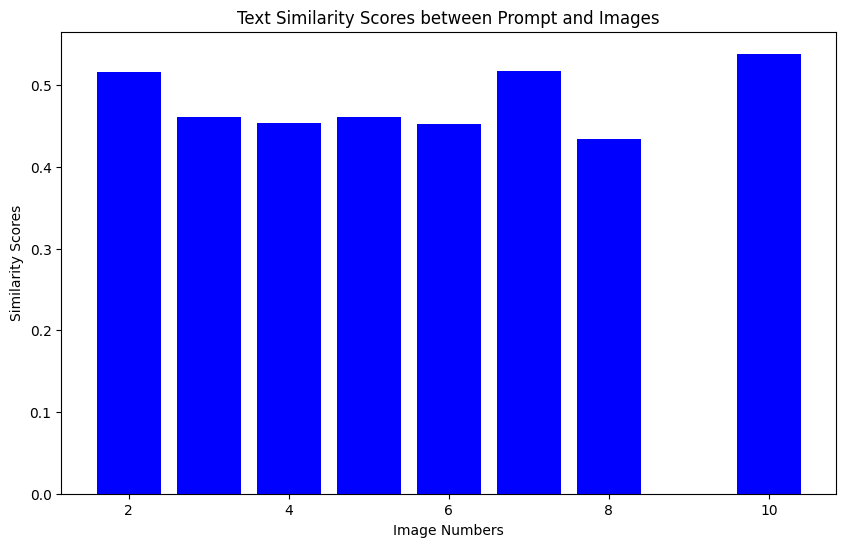

In [27]:
import matplotlib.pyplot as plt

# Plot the scores
plt.figure(figsize=(10, 6))
plt.bar(image_numbers, scores_list, color='blue')
plt.xlabel('Image Numbers')
plt.ylabel('Similarity Scores')
plt.title('Text Similarity Scores between Prompt and Images')
plt.show()

In [33]:
def keep_top_n_values(values, n=3):
    sorted_indices = sorted(range(len(values)), key=lambda k: values[k], reverse=True)
    top_indices = sorted_indices[:n]
    top_values = [values[i] for i in top_indices]
    return top_indices, top_values

top_indices, top_values = keep_top_n_values(scores_list, n=3)
for index, value in zip(top_indices, top_values):
    print(f"Image {image_numbers[index]} - Score: {value}")

Image 10 - Score: 0.5383191108703613
Image 7 - Score: 0.5166597962379456
Image 2 - Score: 0.5160080790519714


In [35]:
def extract_top_images(images_content, top_indices):
    # Split the images_content into individual image descriptions
    image_descriptions = images_content.split('\n')
    
    # Extract and keep only the content of the top images
    top_images_content = [image_descriptions[i - 1] for i in top_indices]

    # Join the content back into a single string
    top_images_content_combined = '\n'.join(top_images_content)

    return top_images_content_combined

# Example usage
top_images_content = extract_top_images(images_content, top_indices)

# Print the content of the top images
print(top_images_content)


image 7: This image is most likely a drawing or art. A dog is standing in front of a large, pink castle with a moat. The dog appears to be looking at the castle, possibly intrigued by its grandeur. The castle has a tall, pointed roof and a clock tower, adding to its majestic appearance. The scene is set in a garden, with a pond nearby. The colors in the image are vibrant, with the pink castle being the main focus. The abnormality in the image is that the dog's eyes are not aligned properly.
image 5: This image is most likely a realistic one. A large, black and white dog is sitting on a stone platform in front of a red castle. The dog appears to be staring at the camera, capturing the viewer's attention. The castle is a prominent feature in the background, with its distinctive red color and intricate design. The dog is the main focus of the image, and its presence adds a sense of adventure and curiosity to the scene.
image 10: This image is most likely a drawing or art. A black dog is w

In [36]:
model, tokenizer = load_model("TheBloke/Mistral-7B-Instruct-v0.2-AWQ")

# Initialize the prompt template and tokenizer
prompt = ""
prompt_template=f'''{prompt}'''

tokens = tokenizer(
    prompt_template,
    return_tensors='pt'
).input_ids.cuda()

# Same as the "self-rewarding language models" paper
generation_params = {
    "do_sample": True,
    "temperature": 0.7,
    "top_p": 0.95,
    "top_k": 40,
    "max_new_tokens": 512/4,
    "repetition_penalty": 1.1
}

# Using the text streamer to stream output one token at a time
streamer = TextStreamer(tokenizer, skip_prompt=True, skip_special_tokens=True)

# SYSTEM_PROMPT to instruct the model on specificities
SYSTEM_PROMPT = "<s>[SYS] Answer the question directly, justify your answer. do not give unecessary comments or discussions.[/SYS]"


In [37]:
prompt = f"{SYSTEM_PROMPT}<s>[INST]based on these dystinct image descriptions \n{top_images_content}\n which one image seems to be the closest and most respecting of this given prompt: '{prompt_list[indice][1]}'. Take into account all the details in the description, image features, colors, numbers, background, realistic aspect...etc. Your answer should be very short and concise. Follow this template: 'Image 1: the described features .. and .. and .. are within this image.'.[/INST]"

tokens = tokenizer(
    prompt,
    return_tensors='pt'
).input_ids.cuda()

generation_output = model.generate(
    tokens,
    pad_token_id=tokenizer.eos_token_id,
    streamer=streamer,
    **generation_params
)

Image 5: A large black and white dog (not specifically a bullmastiff) is present. There is a red castle in the background. However, there is no blue pond, yellow garden, green fountain, or red flag in the image. Therefore, it is not the closest match to the given prompt.


In [46]:
prompt = f"{SYSTEM_PROMPT}<s>[INST]which one of those diffusion-based generated images <<{top_images_content}>> is accuratly respecting the Given PROMPT: '{prompt_list[indice][1]}'. Please pay attention to details in the description and prompt, analyse the common features, colors, backgrounds and select a single Image out of all image description. you only answer should be the Updated PROMPT based on your analysis and make it very concise and very descriptive to the selected image. Follow this template for you answer: 'Image X: PROMPT.' where X is the number of selected image and PROMPT is the updated PROMPT with detailed scene, colors, background, position, orientation.[/INST]"

tokens = tokenizer(
    prompt,
    return_tensors='pt'
).input_ids.cuda()

generation_output = model.generate(
    tokens,
    pad_token_id=tokenizer.eos_token_id,
    streamer=streamer,
    **generation_params
)

Image 5: A blue Bullmastif sits before a red castle, its stance assertive. The castle's red hue dominates the scene, contrasting against the lush green grass beneath the dog's paws. In the distance, a red flag flutters in the breeze. A yellow garden adorns the castle grounds, framing the scene, and a fountain, shimmering blue, lies adjacent to the castle walls.


In [48]:
generated_prompts = tokenizer.decode(generation_output[0]).split(':')
generated_prompts

['<s><s> [SYS] Answer the question directly, justify your answer. do not give unecessary comments or discussions.[/SYS]<s> [INST]which one of those diffusion-based generated images <<image 7',
 " This image is most likely a drawing or art. A dog is standing in front of a large, pink castle with a moat. The dog appears to be looking at the castle, possibly intrigued by its grandeur. The castle has a tall, pointed roof and a clock tower, adding to its majestic appearance. The scene is set in a garden, with a pond nearby. The colors in the image are vibrant, with the pink castle being the main focus. The abnormality in the image is that the dog's eyes are not aligned properly.\nimage 5",
 " This image is most likely a realistic one. A large, black and white dog is sitting on a stone platform in front of a red castle. The dog appears to be staring at the camera, capturing the viewer's attention. The castle is a prominent feature in the background, with its distinctive red color and intrica